In [1]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score,classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tqdm.notebook as tqdm

In [2]:
from NeuralNetwork.dense import Dense
from NeuralNetwork.activations import Sigmoid,Softmax,ReLU
from NeuralNetwork.losses import categorical_crossentropy, categorical_crossentropy_derive
from NeuralNetwork.network import predict

In [3]:
mnist = fetch_openml('mnist_784')

In [4]:
X = mnist.data/255.0
labels = np.array( mnist.target).astype(int)
y = np.squeeze(np.eye(10)[labels])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True)
X_val, y_val = X_train.iloc[:2000],y_train[:2000]

In [5]:
def train(NN, loss, loss_derive, X_train, y_train,X_val,y_val,epoch=20, alpha=0.05, verbose = True):
    X_train = np.reshape(X_train,X_train.shape +(1,))
    y_train = np.reshape(y_train,y_train.shape +(1,))
    X_val = np.reshape(X_val,X_val.shape +(1,))
    y_val = np.reshape(y_val,y_val.shape +(1,))
    error_TS = []
    acc_TS = []
    val_error_TS = []
    val_acc_TS = []
    for e in range(epoch):
        errors= 0
        acc =0
        val_error = 0
        val_acc = 0
        for x, y in zip(X_train, y_train):
            # forward
            out = predict(NN, x)
            if np.argmax(y)==np.argmax(out):
                acc+=1
            # error

            errors+= loss(y, out)

            # backward
            gradient = loss_derive(y, out)
            for layer in reversed(NN):
                gradient = layer.backward(gradient, alpha)

        for x, y in zip(X_val, y_val):
            output = predict(NN, x)
            if np.argmax(y)==np.argmax(output):
                val_acc+=1
            val_error += loss(y, output)
        
        errors/= len(X_train)
        acc /=len(X_train)
        val_error /= len(X_val)
        val_acc /=len(X_val)

        if verbose:
            print(f"{e + 1}/{epoch}, error={round(errors,4)}, accuracy={round(acc,4)}, val_error={round(val_error,4)}, val_accuracy={round(val_acc,4)}")
        error_TS.append(errors)
        acc_TS.append(acc)
        val_error_TS.append(val_error)
        val_acc_TS.append(val_acc)
    return [error_TS,acc_TS,val_error_TS,val_acc_TS]

In [6]:
def graph_train(train_error,train_acc,val_error,val_acc,index=False):
    add_index = ""
    if index:
        add_index+=index
    plt.plot(train_error)
    plt.plot(val_error)
    plt.xlabel("Epochs")
    plt.ylabel("Error")        
    plt.legend(['train error','validation error'])
    plt.savefig("./graph/Error{}.png".format(add_index))
    plt.clf()
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(['train accuracy','validation accuracy'])

    plt.savefig("./graph/Accuracy{}.png".format(add_index))

In [7]:
NN = [Dense(784,40),
      Sigmoid(),
      Dense(40,10),
      Softmax()]

In [8]:
train_error,train_acc,val_error,val_acc = train(NN,categorical_crossentropy,categorical_crossentropy_derive,X_train,y_train,X_val,y_val,alpha=0.06,epoch=20)

1/20, error=0.0451, accuracy=0.8645, val_error=0.0247, val_accuracy=0.9275
2/20, error=0.0252, accuracy=0.9258, val_error=0.0191, val_accuracy=0.947
3/20, error=0.02, accuracy=0.94, val_error=0.0156, val_accuracy=0.9545
4/20, error=0.0169, accuracy=0.9496, val_error=0.0136, val_accuracy=0.961
5/20, error=0.0149, accuracy=0.9558, val_error=0.0118, val_accuracy=0.9675
6/20, error=0.0133, accuracy=0.9599, val_error=0.0103, val_accuracy=0.97
7/20, error=0.0121, accuracy=0.9643, val_error=0.0091, val_accuracy=0.9705
8/20, error=0.011, accuracy=0.9664, val_error=0.0085, val_accuracy=0.975
9/20, error=0.0101, accuracy=0.9699, val_error=0.0085, val_accuracy=0.9765
10/20, error=0.0093, accuracy=0.9719, val_error=0.0078, val_accuracy=0.979
11/20, error=0.0086, accuracy=0.9741, val_error=0.0077, val_accuracy=0.98
12/20, error=0.0081, accuracy=0.9761, val_error=0.0069, val_accuracy=0.9795
13/20, error=0.0077, accuracy=0.9762, val_error=0.0068, val_accuracy=0.978
14/20, error=0.0073, accuracy=0.978

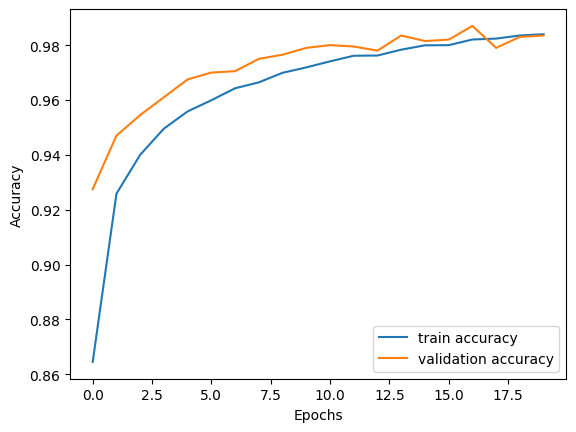

In [9]:
graph_train(train_error,train_acc,val_error,val_acc,index="FINAL")

In [10]:
#make pairs
k=100

In [78]:
from sklearn.utils import shuffle
def get_top(X,labels,k=100):
    #dataset = np.column_stack((X,labels))
    X_sample, labels_sample = shuffle(X, labels, )

    topk = []
    for _class in range(10):
        class_index = np.where(labels_sample==_class)[0][:k]
        topk.append(np.column_stack((X_sample.iloc[class_index],labels_sample[class_index])))
    topk = np.vstack(topk)
    return topk

In [79]:
top100 = get_top(X,labels)
np.random.shuffle(top100)

In [80]:
pairs = []
pair_labels = []
for row1 in top100:
    for row2 in top100:
        pairs.append(np.hstack((row2[:-1],row1[:-1])))
        if row1[-1]==row2[-1]:
            pair_labels.append(1)
        else:
            pair_labels.append(0)

pairs = np.vstack(pairs)
pair_labels = np.array(pair_labels)

In [81]:
X_train,X_val,y_train,y_val = train_test_split(pairs,pair_labels,test_size=0.2,shuffle=True)

In [99]:
def predict_siamese(NN,X,threshold=0.5):
    X_sample = X.reshape(len(X), 2, 784)
    predictions = []
    first_images = []
    second_images = []
    
    for sample in X_sample:
        first_images.append(predict(NN,sample[0].reshape(784,1)))
        second_images.append(predict(NN,sample[1].reshape(784,1)))

    for first,second in zip(first_images,second_images):
        euclidean_dist =np.sqrt(np.sum(np.square(first - second)))
        if euclidean_dist<threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return np.array(predictions)

In [102]:
predictions = predict_siamese(NN,X_train)

In [125]:
def eval(predictions,true_val):
    acc = 0
    for pred,true in zip(predictions,true_val):
        if pred==true:
            acc+=1
    return acc/len(true_val)

In [90]:
topk = get_top(X,labels,k=10)
np.random.shuffle(topk)

In [158]:
def eval_siamese(X_sample,label_sample,k=5):
    topk = get_top(X,labels,k)
    np.random.shuffle(topk)
    predictions = []
    for sample,label in zip(X_sample.to_numpy(),label_sample):
        pairs = []
        pair_labels = []
        for row in topk:
            pairs.append(np.hstack((sample[:],row[:-1])))
            pair_labels.append(row[-1])
        pairs = np.vstack(pairs)
        pair_labels = np.array(pair_labels).astype(int)
        sample_predictions = predict_siamese(NN,pairs)
        predict = np.bincount(pair_labels[sample_predictions==1])
        if predict.size:
            predictions.append(predict.argmax())
        else:
            predictions.append(10)
    acc = eval(np.array(predictions),label_sample.argmax(axis=1))
    return {'k':k,'acc':acc}

In [163]:
outputs = []
for k in tqdm.tqdm([5,10,15,20]):
    output = eval_siamese(X_test,y_test,k=k)
    outputs.append(output)

  0%|          | 0/4 [00:00<?, ?it/s]

In [175]:
outputs

[{'k': 150, 'acc': 0.9486428571428571},
 {'k': 200, 'acc': 0.9485},
 {'k': 300, 'acc': 0.9490714285714286},
 {'k': 500, 'acc': 0.9490714285714286}]

In [176]:
outputs = [{'k': 5, 'acc': 0.9397142857142857},
 {'k': 10, 'acc': 0.9443571428571429},
 {'k': 15, 'acc': 0.9419285714285714},
 {'k': 20, 'acc': 0.9445714285714286},
 {'k': 25, 'acc': 0.9442142857142857},
 {'k': 35, 'acc': 0.9441428571428572},
 {'k': 50, 'acc': 0.9454285714285714},
 {'k': 100, 'acc': 0.9470714285714286},
 {'k': 150, 'acc': 0.9486428571428571},
 {'k': 200, 'acc': 0.9485},
 {'k': 300, 'acc': 0.9490714285714286},
 {'k': 500, 'acc': 0.9490714285714286}]

In [177]:
plots = pd.DataFrame(outputs)

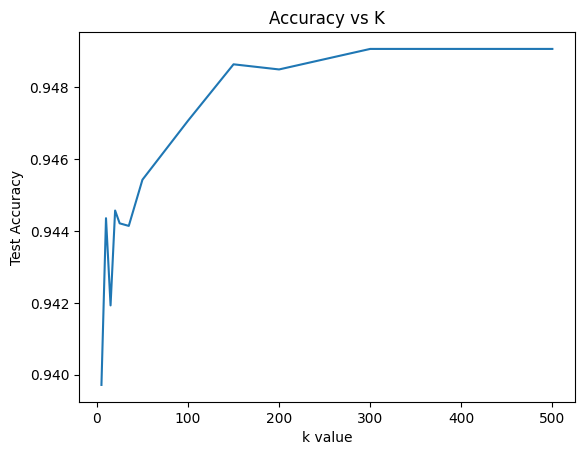

In [178]:
plt.plot(plots['k'],plots['acc'])
plt.title('Accuracy vs K')
plt.xlabel('k value')
plt.ylabel('Test Accuracy')
plt.savefig('./graph/acc_vs_k.png')